In [24]:
from qiskit_aer import AerSimulator, StatevectorSimulator
from qiskit.providers.fake_provider import FakeAlmadenV2, FakeSherbrooke
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.primitives import Estimator, BackendEstimator, Sampler
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd


from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

from GLOBAL_CONFIG import *

In [25]:
variances, losses, weights, scores_train, scores_test = logs_to_methods_data('./Logs-Cancer-v4')

List of a valid archive: ./Logs-Cancer-v4
   Found method: m0
      Found method instance: m0-0
         ... Instance m0-0 renumbered as 0
      Found method instance: m0-1
         ... Instance m0-1 renumbered as 1
      Found method instance: m0-2
         ... Instance m0-2 renumbered as 2
      Found method instance: m0-3
         ... Instance m0-3 renumbered as 3
      Found method instance: m0-4
         ... Instance m0-4 renumbered as 4
      Found method instance: m0-5
         ... Instance m0-5 renumbered as 5
      Found method instance: m0-6
         ... Instance m0-6 renumbered as 6
      Found method instance: m0-7
         ... Instance m0-7 renumbered as 7
      Found method instance: m0-8
         ... Instance m0-8 renumbered as 8
      Found method instance: m0-9
         ... Instance m0-9 renumbered as 9
      Method m0 had 10 valid, 0 missing, and 0 in error instances
   Found method: m1
      Found method instance: m1-0
         ... Instance m1-0 renumbered as 0
     

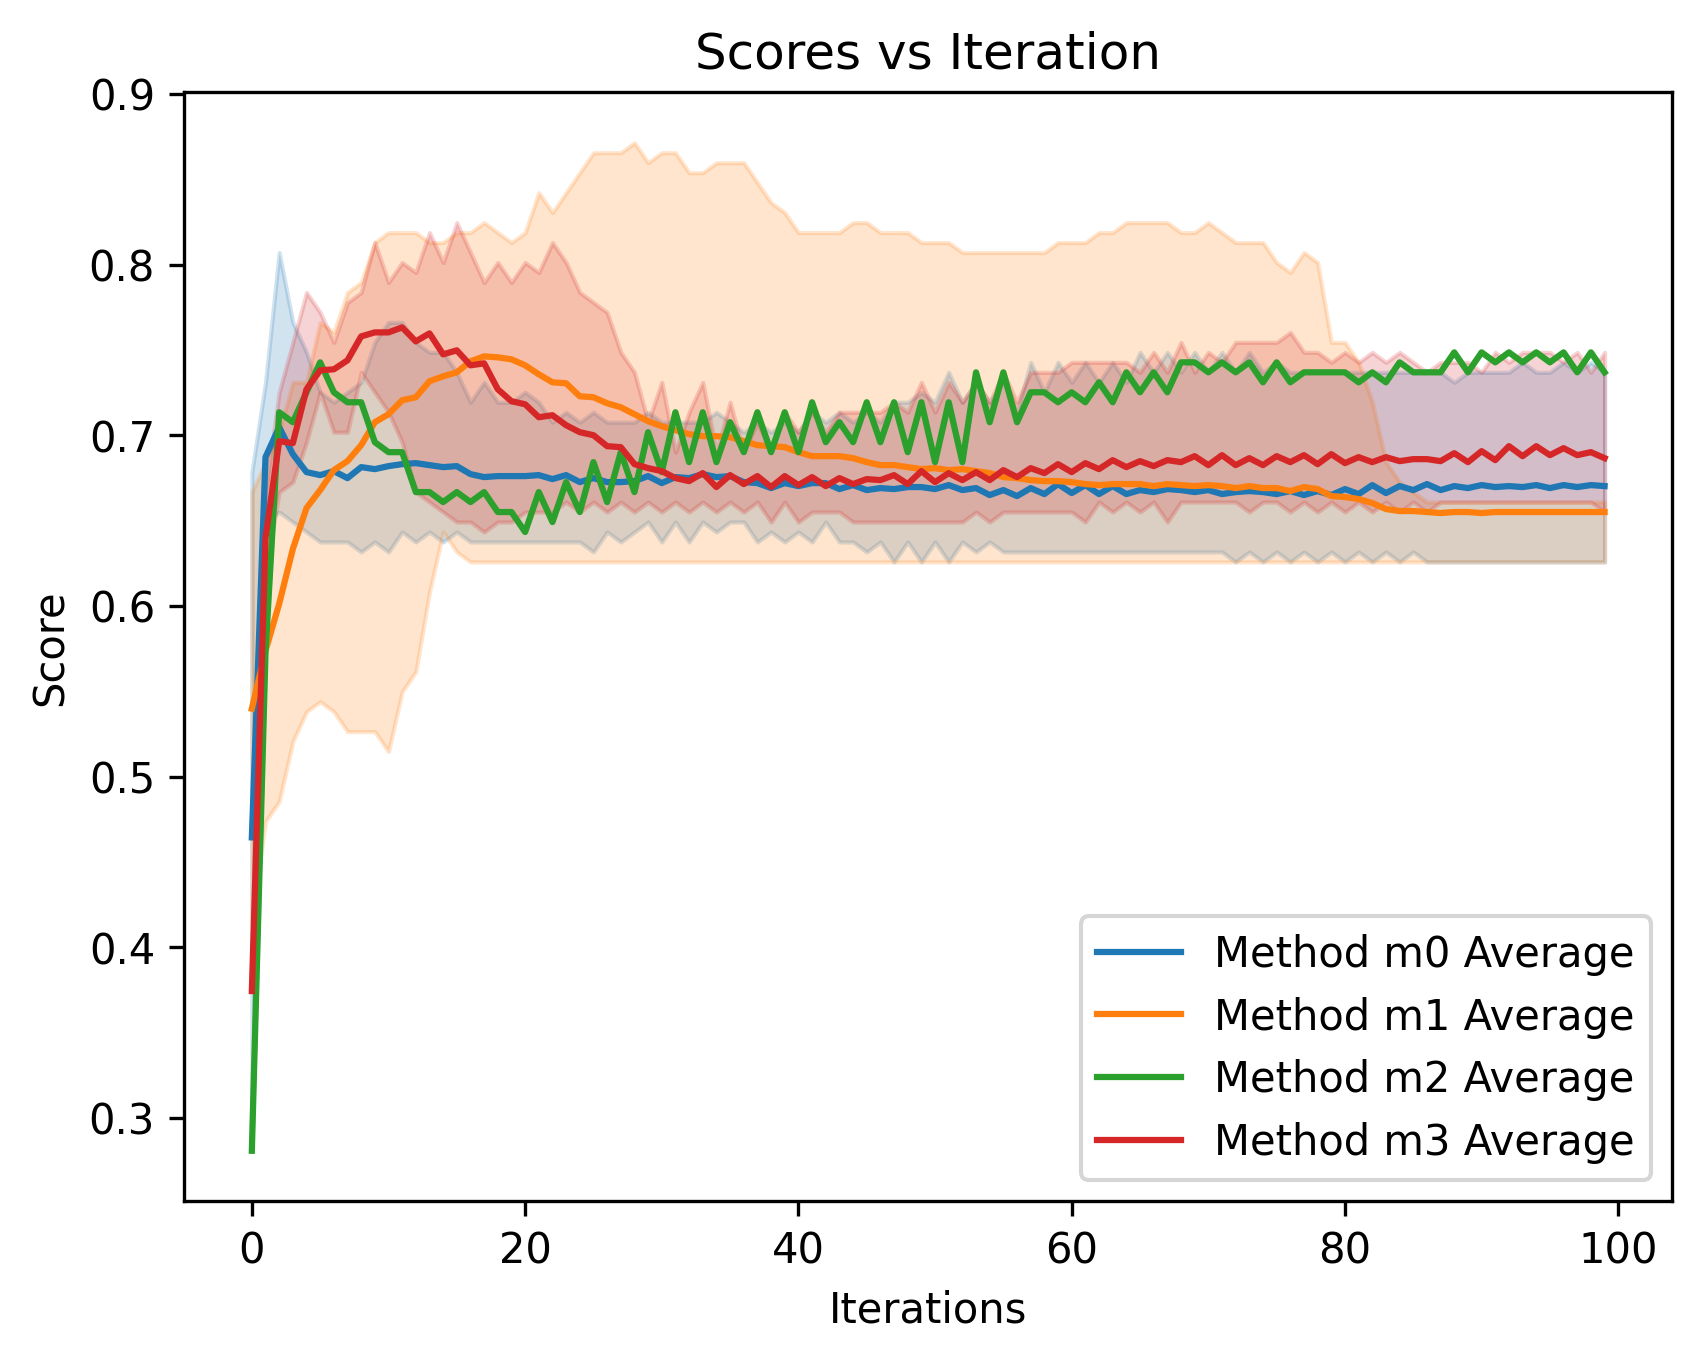

In [26]:
def plot_data_range(data:dict, smooth_weight=0, xlabel='Iterations', ylabel='Score', title='Scores vs Iteration'):
    color = {
        'm0': 'tab:blue', 
        'm1': 'tab:orange' ,
        'm2': 'tab:green', 
        'm3':'tab:red'
        }
    for c in data:
        select = pd.DataFrame(np.reshape(data[c], (len(data[c]), data[c][0].shape[1])))
        
        max = smooth(select.max(), smooth_weight)
        min = smooth(select.min(), smooth_weight)
        mean = smooth(select.mean(), smooth_weight)
        

        plt.plot(range(0, select.shape[1]), mean, color = color[c], label=f'Method {c} Average')

        plt.fill_between(range(0, select.shape[1]), max, min, color = color[c], alpha = 0.2)
    
    # plt.ylim(0.2, 1.1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='lower right')

plot_data_range(scores_test, smooth_weight=0)

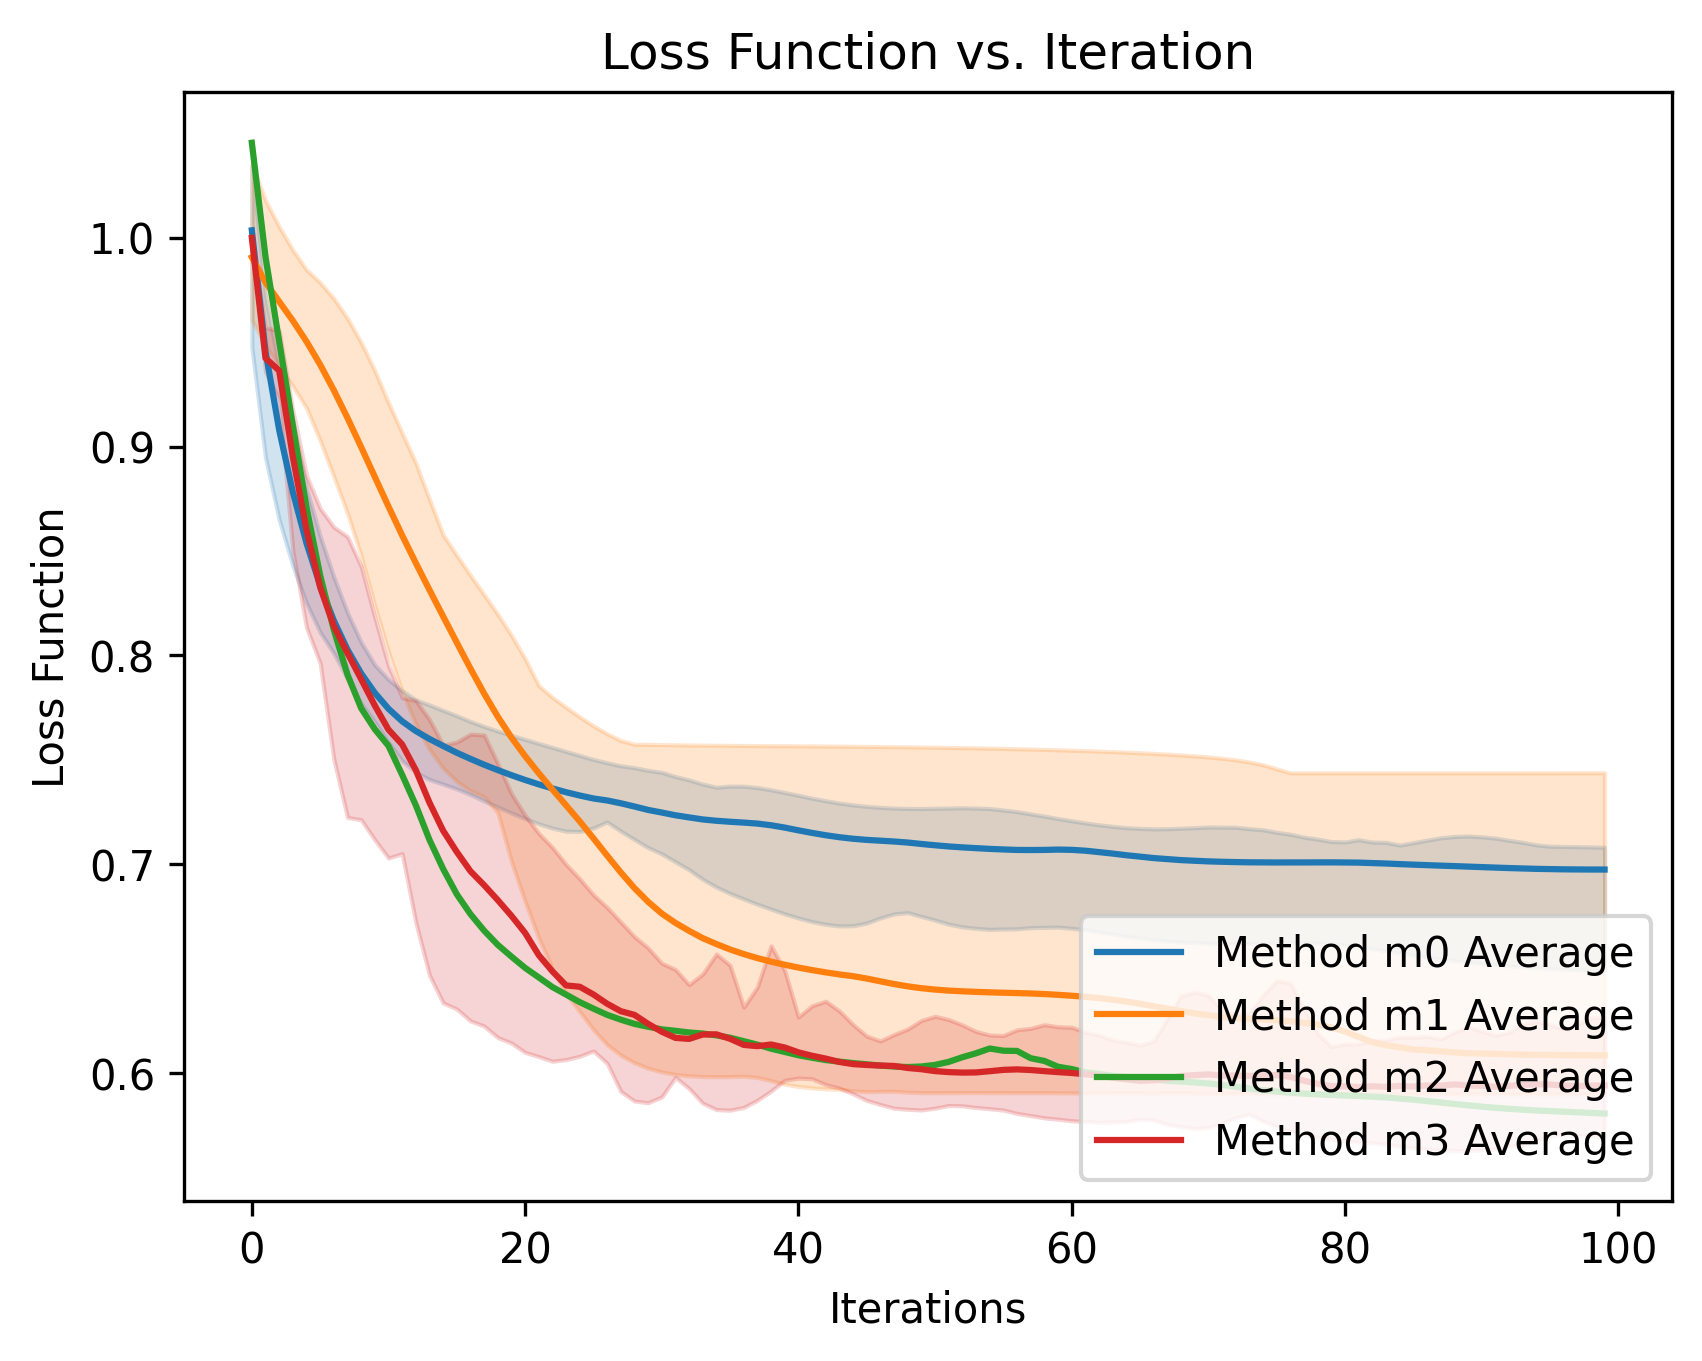

In [27]:
plot_data_range(losses,ylabel='Loss Function', title= 'Loss Function vs. Iteration')

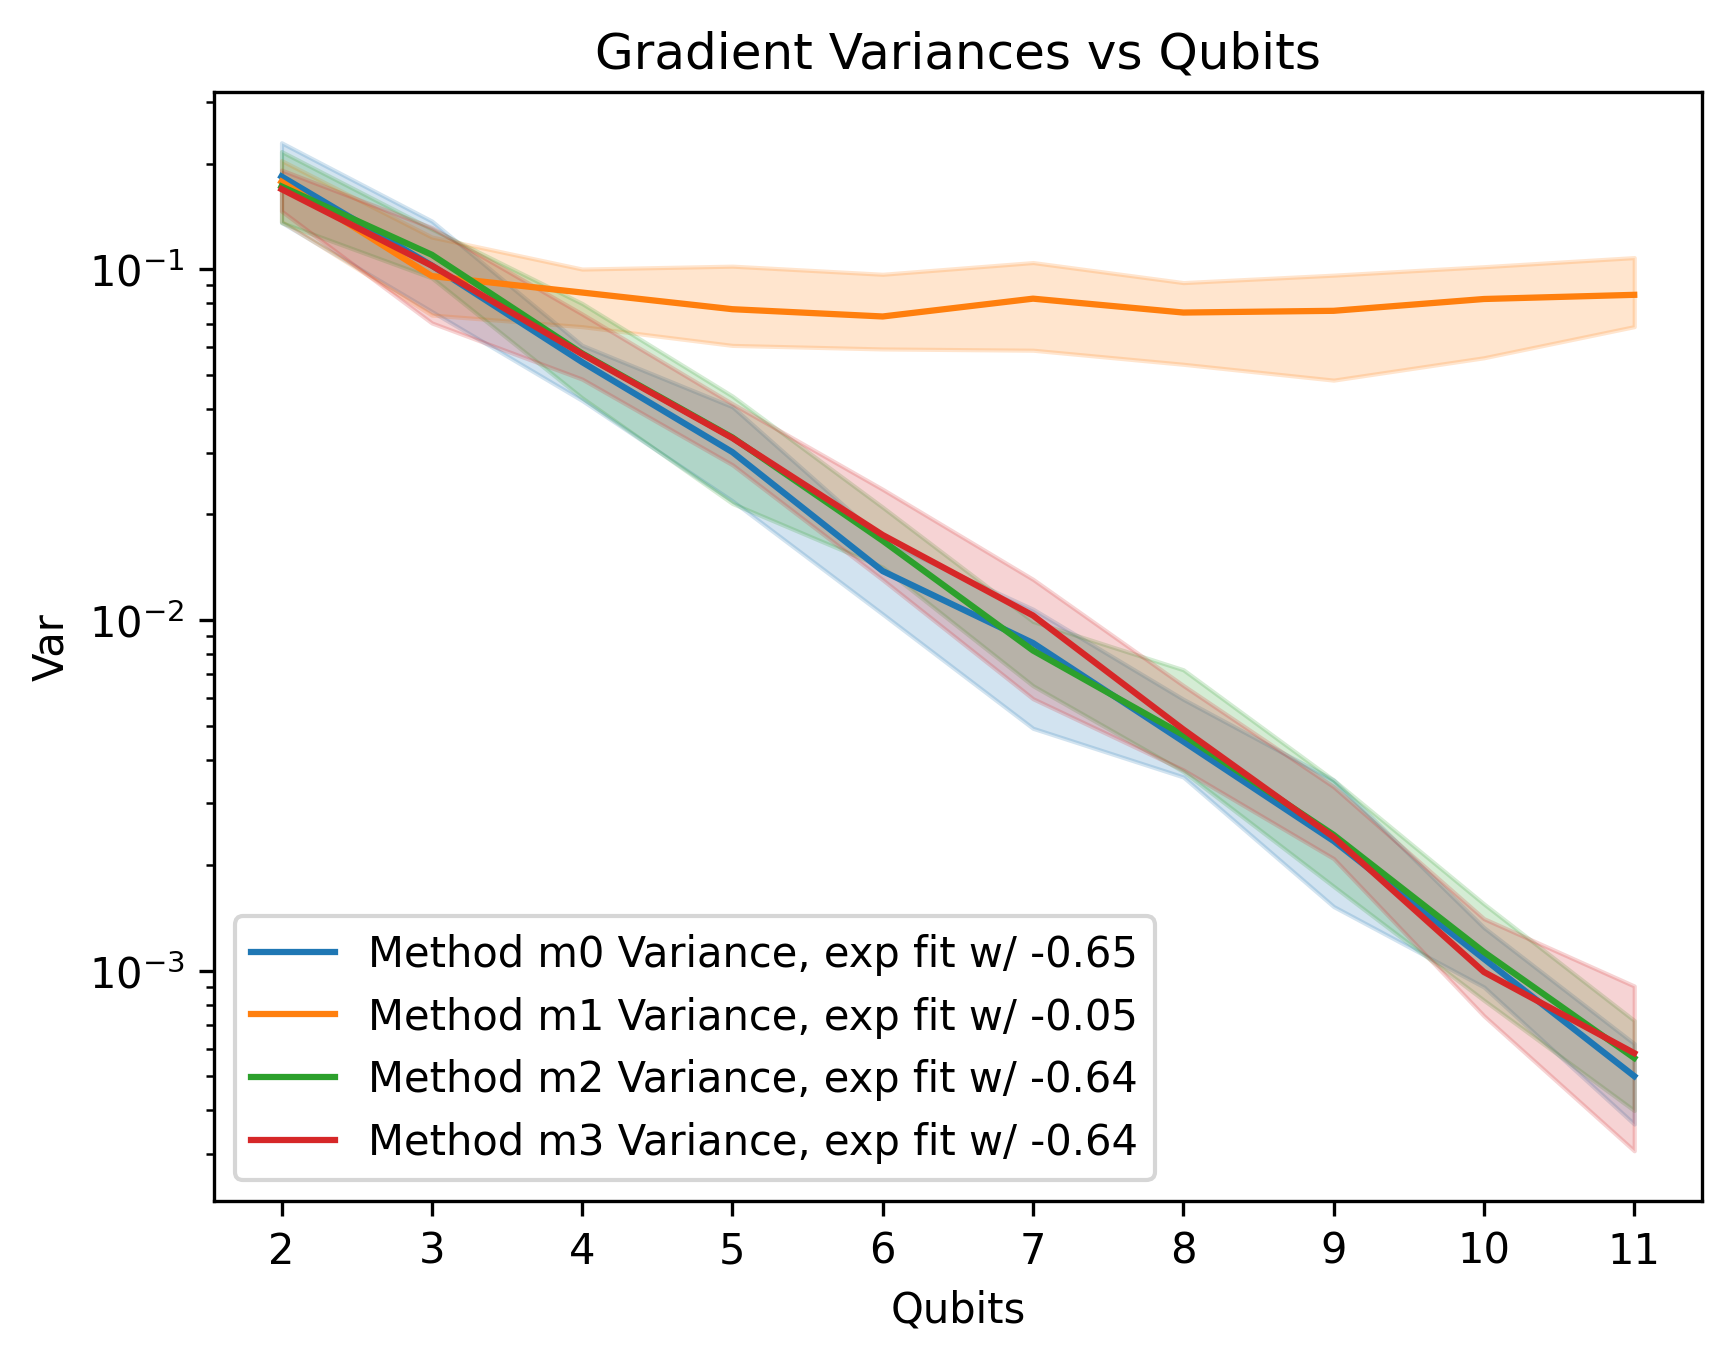

In [28]:
def plotMeanVariance(data:list[float|np.float64], num_qubits:list[int], smooth_weight=0):
    '''
    Plot the variance of the gradient obtained in batch data.

    Args: 
        data - the given data, can be obtained from function getVariance()

        num_qubits - range of number of qubits, eg. range(2, MAX_QUBITS)

        smooth_weight - within range [0, 1], apply smooth to graph, can cause information loss

    '''

    color = {
        'm0': 'tab:blue', 
        'm1': 'tab:orange' ,
        'm2': 'tab:green', 
        'm3':'tab:red'
        }
    for c in data:
        select = pd.DataFrame(np.reshape(data[c], (len(data[c]), data[c][0].shape[1])))
        
        max = smooth(select.max(), smooth_weight)
        min = smooth(select.min(), smooth_weight)
        mean = smooth(select.mean(), smooth_weight)

        fit = np.polyfit(num_qubits, np.log(mean), deg=1)

        plt.semilogy(num_qubits, mean, color = color[c], label=f'Method {c} Variance, exp fit w/ {fit[0]:.2f}')

        plt.fill_between(num_qubits, max, min, color = color[c], alpha = 0.2)
    
    # plt.ylim(0.2, 1.1)
    plt.title('Gradient Variances vs Qubits')
    plt.xlabel('Qubits')
    plt.xticks(num_qubits)
    plt.ylabel('Var')
    plt.legend(loc='best')


num_qubits = list(range(2, MAX_QUBITS))
plotMeanVariance(variances, num_qubits)

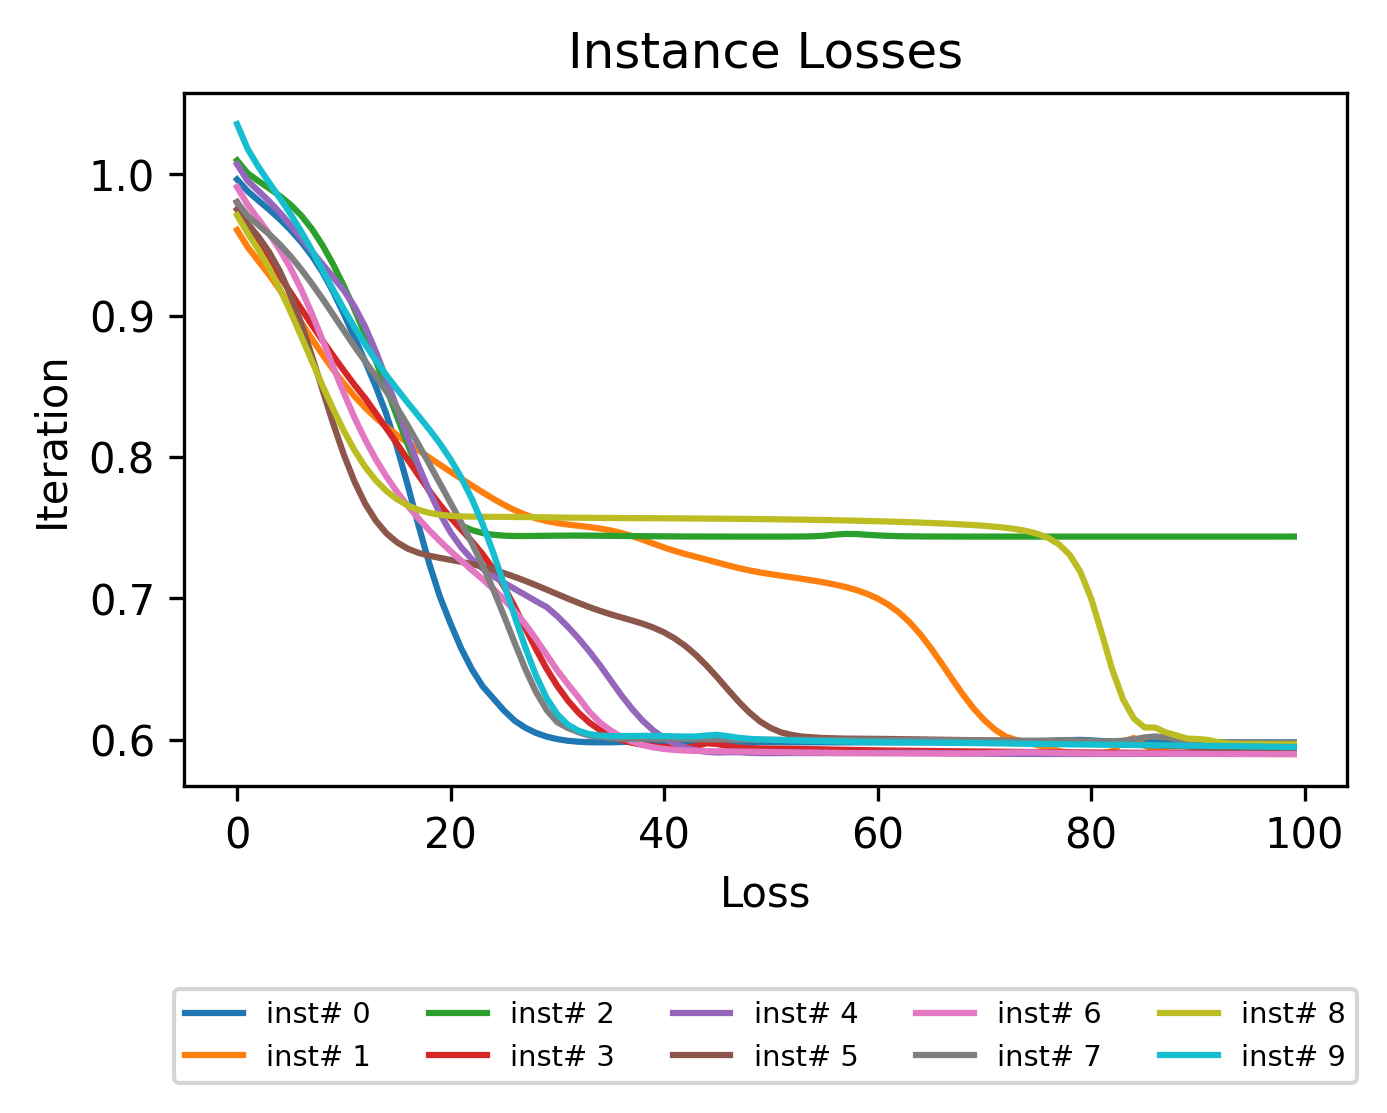

In [29]:
def plot_method_data(losses, title='Instance Losses', dlabel='inst#', xlabel='Loss', ylabel='Iteration'):
    # create figure and axis
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(8)
    
    # setting the axis' labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # transposing (switchung rows and columns) of DataFrame df and
    # plot a line for each column on the axis ax, which was created previously
    for i in range(len(losses)):
        losses[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
    ax.legend([f'{dlabel} {i}' for i in range(len(losses))],
             loc='lower center', bbox_to_anchor=(0.5, -0.45),
             ncol=5, fancybox=True, fontsize='x-small') #, shadow=True)
    plt.title(title)
    plt.show()
    
plot_method_data(losses['m1'])

In [30]:
# Only use in the fist phase

num_qubits = list(range(2, MAX_QUBITS))

# Globak operator for all ansatzes, measure all qubits
G_O = [SparsePauliOp.from_list([('Z'*n, 1)]) for n in num_qubits]

# Local operator for all ansatzes, measere 2 last qubits
L_O = [SparsePauliOp.from_list([('I' * (n - 2)+'Z'*2, 1)]) for n in num_qubits]

In [31]:
# backend = FakeSherbrooke()
# estimator = BackendEstimator(backend)
estimator = Estimator()

In [32]:
X_train, X_val, y_train, y_val = cancer_data(PCA_n = FEATURE_DIM)
# X_train, X_val, y_train, y_val = fetch_mnist(PCA_n = FEATURE_DIM, data_size=DATA_SIZE)
# X_train, X_val, y_train, y_val = iris(pd=False, PCA_n=None)

X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).to(torch.float32)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).to(torch.float32)

Training set: 398 samples
Testing set: 171 samples
Number of features: 4
PCA Explained variance: [4.43782605e+05 7.31010006e+03 7.03833742e+02 5.46487379e+01]
Classes:[0 1]; Encoded as: [-1  1]


In [33]:
anz = AnsatzGenerator(num_qubits = MAX_QUBITS, reps = MAX_REPS, entanglement='linear')
print("Ansatz Method 0 stats:")
print(f"{' - Parameters:':<20} {anz.num_parameters: >5}")
print(f"{' - Depth:':<20} {anz.decompose().depth(): >5}")

print('\n')

ibl = preTrainedBlockGenerator(num_qubits = MAX_QUBITS, num_blocks = 3, overlay = 2)['circuit']
print("Identity Block Method 3 stats:")
print(f"{' - Parameters:':<20} {ibl.num_parameters: >5}")
print(f"{' - Depth:':<20} {ibl.depth(): >5}")

Ansatz Method 0 stats:
 - Parameters:         156
 - Depth:               46


Identity Block Method 3 stats:
 - Parameters:         156
 - Depth:               96


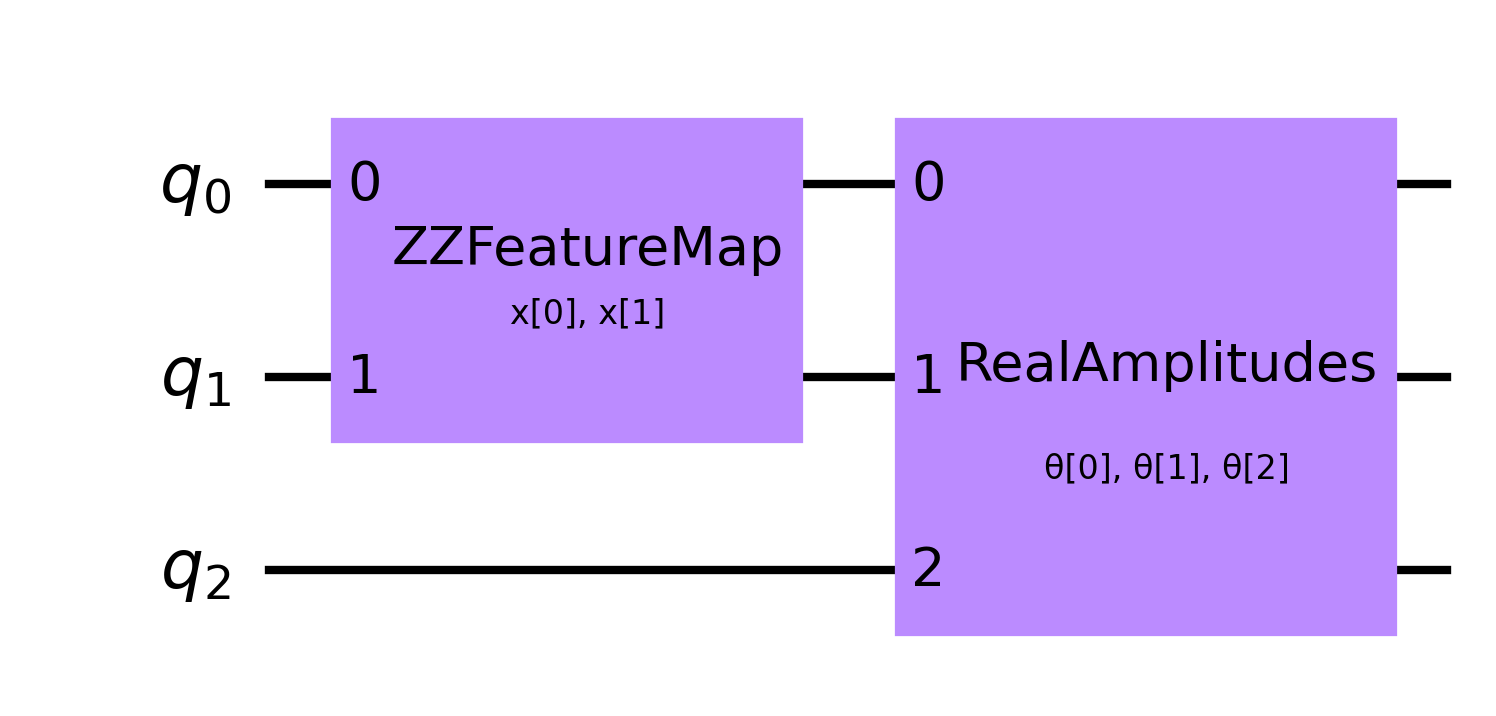

In [40]:
feature_map = featureMapGenerator(2)
ansatz = AnsatzGenerator(num_qubits=3, reps=0, entanglement=ENTANGLEMENT)

experimental_qc = circuitBuilder(feature_map, ansatz, 'middle')


len(experimental_qc.parameters) # 12

experimental_qc.draw('mpl')

In [12]:
def LLMinimizePrimitives(circuit: QuantumCircuit, optimiser:optimizers, estimator: Estimator):
    operator = SparsePauliOp.from_list([('I' * (circuit.num_qubits - 2)+'Z'*2, 1)])

    initial_point = np.zeros(circuit.num_parameters)

    bouned_circuit = circuit.assign_parameters(initial_point)

    expectation = Statevector(bouned_circuit)
    
    state = expectation.evolve(operator)

    PShiftGradient = ParamShiftEstimatorGradient(state)

    def loss(x):
        # values = dict(zip(circuit.parameters, x))
        return np.real(estimator.run([circuit], observables=[operator], parameter_values=[x]).result().values)
    
    def gradient(x):
        # values = dict(zip(circuit.parameters, x))
        return np.real(PShiftGradient.run(parameter_values=[x]))

    res = optimiser.minimize(fun=loss, jac=gradient, x0=initial_point)

    return res


def LayerwiseTrainingPrimitives(ansatz: QuantumCircuit, max_num_layers: int, optimizer = COBYLA(maxiter=5), estimator = Estimator()):
    optimal_parameters = []

    for reps in range(1, max_num_layers+1):
        ansatz.reps = reps

        # bind already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        partially_bound = ansatz.assign_parameters(values_dict)

        res = LLMinimizePrimitives(partially_bound, optimizer, estimator)
        print('Circuit rep:', reps, 'best value:', res.fun)
        optimal_parameters += list(res.x)

    return optimal_parameters


# feature_map = featureMapGenerator(FEATURE_DIM)
# ansatz = AnsatzGenerator(2, reps=3, entanglement=ENTANGLEMENT)

# initial_point = LayerwiseTrainingPrimitives(ansatz, MAX_REPS, optimizer=COBYLA(maxiter=50), estimator=Estimator())

In [13]:
qnn = EstimatorQNN(
    circuit=experimental_qc,
    estimator=estimator,
    observables=GLOBAL_OPERATOR,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

In [14]:
model = TorchConnector(qnn)
loss_function = nn.L1Loss() # nn.MSELoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=0.05)

model, losses, accuracy_train, accuracy_test, weights = train(
    model, 
    10, 
    X_train_t,
    y_train_t,
    X_val_t,
    y_val_t,
    optimizer = optimizer, 
    loss_function = loss_function
)

Epoch      Loss                 Train Accuracy   Test Accuracy   


ValueError: The number of qubits of the 0-th circuit (12) does not match the number of qubits of the 0-th observable (8).

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)

data = [pd.DataFrame(accuracy_test).astype('float').T]
# Plot data
for i in range(len(data)):
    data[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
ax.legend([f'inst {i}' for i in range(len(data))])
plt.title('instace losses')
plt.show()  